# Flow-meter data analysis

**Here's what I'm thinking:** I was originally planning to do a [Holt-Winters analysis](https://en.wikipedia.org/wiki/Exponential_smoothing#Triple_exponential_smoothing), which is a generalization of a moving average that includes periodic and trend terms (keeping only the periodic). However, that kind of analysis assumes that the periods align; it's usually applied to day-of-week or month-of-year variations.

An important fact that even the current simulated data doesn't capture is that a patient can initiate a breath at any time. A breath will be forced after a set period of time if the patient doesn't initiate it, but we shouldn't be planning for the cases in which the breath rate is exclusively driven by the machine.

The most important quantities, it seems, are the inhale compliance and exhale compliance, where compliance is ΔV/ΔP, how much the lungs stretch (to fill volume) in response to applied force (pressure), because changes in compliance is what causes lung collapse and death in Covid-19 patients. Also of importance is the end-of-exhale (before the next inhale) pressure, called PEEP in the medical jargon.

Measuring volume and pressure are not difficult, but for cleaner alarms, we want to measure them at specific parts of the cycle: the active inhale leg of the cycle, the active exhale leg of the cycle, and in between those two. **I think that the most important task is to identify the legs of the cycle, despite the fact that breaths may start at any time.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
os.chdir("..")
import sim.sim

Get some simulated data.

In [3]:
times, breaths, flow, volume, pressure = sim.sim.make()

Volume is just the integral of flow.

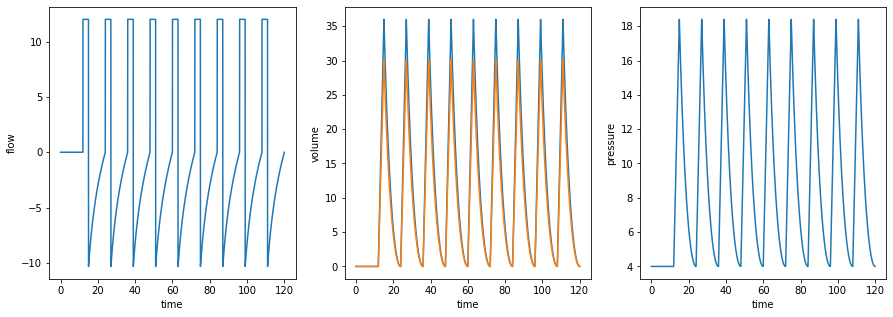

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(times, flow)
ax1.set_xlabel("time")
ax1.set_ylabel("flow")

ax2.plot(times, volume)
ax2.plot(times, np.cumsum(flow) / (times[-1] - times[0]))
ax2.set_xlabel("time")
ax2.set_ylabel("volume")

ax3.plot(times, pressure)
ax3.set_xlabel("time")
ax3.set_ylabel("pressure");

These data are too regular. I can't fix the regularity of the breathing, but I can generally "fuzz" the points, dropping random ones and smearing their values.

How much should they be fuzzed? I don't know! But it's more the procedure that counts at this stage.

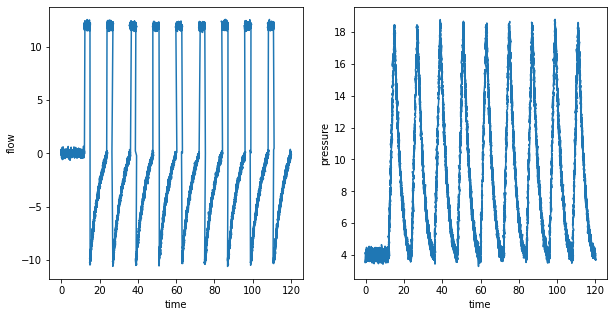

In [9]:
def fuzz(times, flow, pressure):
    mask = np.random.randint(0, 5, len(times)) != 0
    length = np.count_nonzero(mask)
    times = times[mask] + np.random.normal(0, 0.2, length)
    flow = flow[mask] + np.random.normal(0, 0.2, length)
    pressure = pressure[mask] + np.random.normal(0, 0.2, length)
    return times, flow, pressure

fuzzed_times, fuzzed_flow, fuzzed_pressure = fuzz(times, flow, pressure)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(fuzzed_times, fuzzed_flow)
ax1.set_xlabel("time")
ax1.set_ylabel("flow")
ax2.plot(fuzzed_times, fuzzed_pressure)
ax2.set_xlabel("time")
ax2.set_ylabel("pressure");

Next, I'm going to apply a smoothing procedure to fix the fuzz.

This is not just to deal with noise; it's also to turn the data from what is essentially a scatter-plot into what is essentially a curve. The smoothed function can be sampled as finely as we want, not limited by the granularity of the data, so this is a change in data type from points to a function.

My favorite technique is [local regression](https://en.wikipedia.org/wiki/Local_regression), which is normally thought of as an expensive procedure, but 